# BIN 11 center failure Fab B PCM vs FT Failure Rate Analysis



**OVERVIEW**

In Semiconductor foundry engineering, we need to do fab transfer time to time to resolve any potential capacity issues.  That means we need to transfer a running process in Fab A  to Fab B and ensure the performance matches between the two fabs.

WAT (wafer acceptance test) is a wafer level parametric test using scribe line test kits to check the wafer circuit performance.

After wafers finish WAT and fab process, they are moved to assembly and Final test.   The final product’s performance can be measured by Final test data with ATE test equipment.

In the fab transfer from Fab A to Fab B, the ultimate goal is to make sure the Final test data yield are comparable.

In a Fab transfer project we have, we found out Fab B shows ~0.7% higher yield loss than Fab A. 

So it is critical to find out what could cause the yield delta and improve the yield in Fab B by process tuning.  WAT is a key to find out the wafer process related parameters.  So a FT vs WAT correlation and feature findings are needed for debug.



In [6]:
import numpy as np
import pandas as pd



In [7]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

In [8]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

### Data Understanding

PCM (process control monitor) parameter data understanding with info (), describe().  Check null values.
From the data cleaning, data are a mix of objects and numerical data, and data contains NaN


In [9]:
## load data to a dataframe to check the data inforamtion
## check the columns and datatype with info()
## check statistics with describe()
## check what the data look like by using head()
pcm=pd.read_csv('data/Austin-PCM.csv')
print(pcm.info())
print(pcm.describe())
print(pcm.isnull().sum())
pcm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Columns: 123 entries, Fab to Vtl_P4OD
dtypes: float64(107), int64(10), object(6)
memory usage: 238.4+ KB
None
         Fab  Wafer Number        PCMx        PCMy           1          11  \
count  248.0    248.000000  248.000000  248.000000  248.000000  248.000000   
mean     0.0     14.528226   -0.427419   -0.161290    0.952006    0.001187   
std      0.0      2.872318    1.795962    2.321828    0.169091    0.010622   
min      0.0     10.000000   -3.000000   -4.000000    0.000000    0.000000   
25%      0.0     12.000000   -2.000000   -2.000000    0.980952    0.000000   
50%      0.0     15.000000    0.000000    0.000000    0.990476    0.000000   
75%      0.0     17.000000    1.000000    2.000000    0.995238    0.000000   
max      0.0     19.000000    3.000000    4.000000    1.000000    0.156250   

               12          13          16          18  ...     Vtl_N45  \
count  248.000000  248.000000  248.000000

,Fab,Source Lot,Wafer,Wafer Number,PCMx,PCMy,1,11,12,13,...,Vtl_N45,Vtl_N4N,Vtl_N4OD,Vtl_NFGD,Vtl_NNGD,Vtl_P4,Vtl_P45,Vtl_P45L,Vtl_P4L,Vtl_P4OD
0,0,N9TK60.S,N9TK60_14,14,-3,-3,0.919048,0.0,0.0,0.009524,...,0.735,0.300781,0.640,1.832,0.815,-0.619,-0.872,-0.767,NaN,-0.593
1,0,N9TK60.S,N9TK60_14,14,-3,-1,0.976190,0.0,0.0,0.009524,...,0.746,0.298340,0.626,1.834,0.816,-0.608,-0.862,-0.762,NaN,-0.589
2,0,N9TK60.S,N9TK60_14,14,-3,1,0.985714,0.0,0.0,0.014286,...,0.731,0.300781,0.616,1.834,0.820,-0.606,-0.868,-0.763,NaN,-0.578
3,0,N9TK60.S,N9TK60_14,14,-3,3,0.964286,0.0,0.0,0.000000,...,0.750,0.305664,0.628,1.833,0.817,-0.618,-0.869,-0.769,NaN,-0.591
4,0,N9TK60.S,N9TK60_14,14,-2,-4,0.993750,0.0,0.0,0.006250,...,0.739,0.300781,0.630,1.828,0.810,-0.623,-0.862,-0.772,NaN,-0.593


### Data Preparation

Clean up the data and remove null values. 

In [10]:
## Data cleaning by dropping all NaN data
pcm = pcm.dropna(axis=1)
print(pcm.isnull().sum()) # check to see if any null values in any columns.
pcm.isnull().sum().to_csv('data/null_summary.csv')
pcm.to_csv('data/Austin-PCM-clean.csv')
## Drop wafer (it is duplicating with wafer number)
pcm = pcm.drop('Wafer',axis =1)
pcm.head()

Fab             0
Source Lot      0
Wafer           0
Wafer Number    0
PCMx            0
               ..
Vtl_NNGD        0
Vtl_P4          0
Vtl_P45         0
Vtl_P45L        0
Vtl_P4OD        0
Length: 121, dtype: int64


,Fab,Source Lot,Wafer Number,PCMx,PCMy,1,11,12,13,16,...,Vtl_N44,Vtl_N45,Vtl_N4N,Vtl_N4OD,Vtl_NFGD,Vtl_NNGD,Vtl_P4,Vtl_P45,Vtl_P45L,Vtl_P4OD
0,0,N9TK60.S,14,-3,-3,0.919048,0.0,0.0,0.009524,0.0,...,0.570,0.735,0.300781,0.640,1.832,0.815,-0.619,-0.872,-0.767,-0.593
1,0,N9TK60.S,14,-3,-1,0.976190,0.0,0.0,0.009524,0.0,...,0.587,0.746,0.298340,0.626,1.834,0.816,-0.608,-0.862,-0.762,-0.589
2,0,N9TK60.S,14,-3,1,0.985714,0.0,0.0,0.014286,0.0,...,0.590,0.731,0.300781,0.616,1.834,0.820,-0.606,-0.868,-0.763,-0.578
3,0,N9TK60.S,14,-3,3,0.964286,0.0,0.0,0.000000,0.0,...,0.581,0.750,0.305664,0.628,1.833,0.817,-0.618,-0.869,-0.769,-0.591
4,0,N9TK60.S,14,-2,-4,0.993750,0.0,0.0,0.006250,0.0,...,0.578,0.739,0.300781,0.630,1.828,0.810,-0.623,-0.862,-0.772,-0.593


In [11]:
# use nunique() function to check all object columns to see how many unique categories for each column
# Check how many states in the data by using unique() function.  
print(pcm.info())
print(pcm[make_column_selector(dtype_include='object')].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Columns: 120 entries, Fab to Vtl_P4OD
dtypes: float64(105), int64(10), object(5)
memory usage: 232.6+ KB
None
Source Lot     1
Lot            1
Wafer ID      10
Lot ID         1
Part ID        1
dtype: int64


In [12]:
# Drop wafer ID, lot ID and Part ID
print(pcm.columns)
pcm = pcm.drop(columns=['Wafer ID','Lot ID','Part ID','PCMx','PCMy'])
pcm = pcm.drop(columns =['1','11','12','16','18','19','22','23','26','27','28','29','30','42','43','44','8','9','99','13'])
pcm = pcm.drop(columns=['Source Lot','Wafer Number','Count()','Lot'])
#print(pcm['Source Lot'].unique())

Index(['Fab', 'Source Lot', 'Wafer Number', 'PCMx', 'PCMy', '1', '11', '12',
       '13', '16',
       ...
       'Vtl_N44', 'Vtl_N45', 'Vtl_N4N', 'Vtl_N4OD', 'Vtl_NFGD', 'Vtl_NNGD',
       'Vtl_P4', 'Vtl_P45', 'Vtl_P45L', 'Vtl_P4OD'],
      dtype='object', length=120)


In [13]:
## Check pcm data again to see which column is object
print(pcm[make_column_selector(dtype_include='object')].nunique())

Series([], dtype: float64)


In [14]:
## Use make_column_transformer to convert all objects using OneHotEncoder, then standardize the numerical data with standardscaler

col_transformer= make_column_transformer((StandardScaler(),make_column_selector(dtype_include='number')))

## Use fit_transform to transform the car dataframe
pcm_transformed=col_transformer.fit_transform(pcm)

## Get numerical column names out by using get_feature_names_out()
## col_transformer.transformers_[0]:This accesses the first tuple in the transformers_ list of the col_transformer object.
##col_transformer.transformers_[0][1]:  This access the second element of the first tuples, which is the StandardScaler

num_features=col_transformer.transformers_[0][1].get_feature_names_out()
## Convert back to dataframe
transformed_pcm = pd.DataFrame(pcm_transformed, columns=num_features)
#transformed_pcm = transformed_pcm.dropna()

## prepare the feature dataset as X_pcm and the yield as y_pcm
X_pcm = transformed_pcm.drop('VPOR_UPPER_yield',axis =1)
y_pcm = transformed_pcm['VPOR_UPPER_yield']
X_pcm.head()


,Fab,Site ID,BV_N4,BV_N44,BV_N45,BV_N45SA,BV_N46SA,BV_N4OD,BV_N5A6CB,BV_N5A6SB,...,Vtl_N44,Vtl_N45,Vtl_N4N,Vtl_N4OD,Vtl_NFGD,Vtl_NNGD,Vtl_P4,Vtl_P45,Vtl_P45L,Vtl_P4OD
0,0.0,-1.226045,-0.003448,0.015987,-0.103259,0.096411,-1.016261,-0.042648,0.271758,0.033058,...,-0.188101,-0.155017,-0.045832,0.070344,-0.080012,-0.371019,-0.156947,0.084580,0.125057,-0.083271
1,0.0,-1.354612,-0.003448,0.015987,-0.103259,0.096411,-1.016261,-0.042648,-0.388986,0.033058,...,-0.077820,-0.078338,-0.068428,-0.116952,-0.032879,-0.179326,0.033174,0.158726,0.170692,-0.032059
2,0.0,-1.483178,-0.003448,0.015987,-0.103259,-0.195174,0.983999,0.100280,0.271758,0.033058,...,-0.058358,-0.182900,-0.045832,-0.250734,-0.032879,0.587448,0.067741,0.114239,0.161565,0.108773
3,0.0,-1.611744,0.139082,0.015987,-0.103259,-0.195174,-1.016261,0.100280,-0.388986,0.033058,...,-0.116743,-0.050454,-0.000637,-0.090195,-0.056446,0.012367,-0.139664,0.106824,0.106802,-0.057665
4,0.0,-1.097479,-0.003448,0.015987,-0.103259,-0.195174,-1.016261,-0.042648,-0.388986,0.033058,...,-0.136204,-0.127134,-0.045832,-0.063439,-0.174278,-1.329486,-0.226082,0.158726,0.079421,-0.083271


### Modeling

Ridge Model and Lasso Model with GridSearchCV and Pipleline+ PCA

In [15]:
## Split the cleaned X_car and y_car with train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_pcm,y_pcm, test_size = 0.2, random_state =42)


In [16]:
# Build a pipeline with PCA to reduce the features to 5
# Use Ridge model with default alpha value

train_preds_1 =''
test_preds_1 =''
train_mse_1=''
test_mse_1=''
ridge_grid=''

pipe = Pipeline([('pca',PCA(n_components=5)),('model', Ridge())])
pipe.fit(X_train,y_train)
train_preds_1 =pipe.predict(X_train)
test_preds_1 = pipe.predict(X_test)
train_mse_1 = mean_squared_error(train_preds_1,y_train)
test_mse_1 = mean_squared_error(test_preds_1,y_test)
print(f'Ridge Train MSE alpha=1: {train_mse_1}')
print(f'Ridge Test MSE alpha=1: {test_mse_1}')

## To see the explained variance ratio of each principal component
explained_variance = pipe.named_steps['pca'].explained_variance_ratio_
print(f"explained variance ratio of the PCA components:{explained_variance}")

## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Determine the number of components needed to reach 80% variance. 
# If the cumulative explained variance with PCA =5 is less than 80%, then the num_components will return 1.
num_components = np.argmax(cumulative_explained_variance >= 0.8) + 1
print("Number of components to reach 80% variance:", num_components)
pipe

print("################################################################################")
## Add in GridSearchCV to check the best Alpha for Ridge model with Apha from 0-4 with 5 steps
ridge_para_dict=''
ridge_pipe=''
ridge_train_mse=''
ridge_test_mse=''

ridge_param_dict = {'model_s__alpha': np.linspace(0, 2000, 10)}
ridge_pipe = Pipeline([('pca_s',PCA(n_components=5)),('model_s', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe,param_grid = ridge_param_dict)
ridge_grid.fit(X_train,y_train)
ridge_train_preds=ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(ridge_train_preds,y_train)
ridge_test_mse = mean_squared_error(ridge_test_preds,y_test)
print(f'Train MSE with Gridsearch: {ridge_train_mse}')
print(f'Test MSE with Gridsearch: {ridge_test_mse}')
## To see the explained variance ratio of each principal component
explained_variance = pipe.named_steps['pca'].explained_variance_ratio_
print(f"explained variance ratio of the PCA components:{explained_variance}")

## Find the best alpha
best_alpha=ridge_grid.best_params_['model_s__alpha']
print("best alpha value",best_alpha)


## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)
## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)


Ridge Train MSE alpha=1: 1.211963270374064
Ridge Test MSE alpha=1: 0.07230191487360094
explained variance ratio of the PCA components:[0.4989667  0.14183691 0.07027911 0.04718128 0.03443917]
Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317]
Number of components to reach 80% variance: 1
################################################################################
Train MSE with Gridsearch: 1.2183192692868403
Test MSE with Gridsearch: 0.04657541516435319
explained variance ratio of the PCA components:[0.4989667  0.14183691 0.07027911 0.04718128 0.03443917]
best alpha value 666.6666666666667
Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317]


In [17]:
# Build a pipeline with PCA to reduce the features to 5 and Lasso regression
# Use Lasso model 
train_preds_2 =''
test_preds_2 =''
train_mse_2=''
test_mse_2=''
pipe = Pipeline([('pca',PCA(n_components=5)),('model', Lasso())])
pipe.fit(X_train,y_train)
train_preds_2 =pipe.predict(X_train)
test_preds_2 = pipe.predict(X_test)
train_mse_2 = mean_squared_error(train_preds_2,y_train)
test_mse_2 = mean_squared_error(test_preds_2, y_test)
print(f'lasso Train MSE: {train_mse_2}')
print(f'lasso Test MSE: {test_mse_2}')
pipe

lasso Train MSE: 1.2461000258683739
lasso Test MSE: 0.03186912421811693


Pipeline(steps=[('pca', PCA(n_components=5)), ('model', Lasso())])

### Optimize Models

With some simple Ridge and Lasso model completed, try to optimize the Ridge model with the following steps:
1. Build a Pipeline with PCA and Ridge model
2. Optimize the Ridge model with hyper parameter of Alpha and PCA components to achieve > 95% of explained varaiance.

Train MSE with Gridsearch: 1.2179761244535807
Test MSE with Gridsearch: 0.02721533245357877
explained variance ratio of the PCA components:[0.4989667  0.14183691 0.07027911 0.04718128 0.03443917 0.03119678
 0.0214938  0.01779297 0.01472297 0.01237328 0.01202568 0.01076626
 0.01036021 0.0092242  0.00849651 0.0073644  0.00670744 0.00585097
 0.00478256 0.00437512]
best alpha value 2000.0
Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317 0.82389995
 0.84539375 0.86318672 0.8779097  0.89028298 0.90230866 0.91307492
 0.92343513 0.93265932 0.94115583 0.94852023 0.95522767 0.96107864
 0.9658612  0.97023632]
Number of components to reach 95% variance: 17


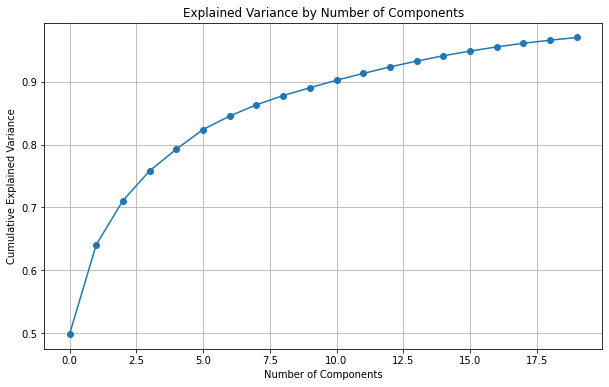

 
 Top 10 features which impact BIN11 failures:
        Feature  Coefficient
71  Rs_PODRPO2     0.012936
53   Iof_PTM9A    -0.010889
16   Cmim40X50     0.010483
58      Rc_TV1    -0.010032
65  Rs_NODRPO2     0.009208
61      Rs_HRI     0.008754
49     Iof_P45    -0.008469
67   Rs_NW_STI     0.008355
66  Rs_NPORPO2     0.008239
72  Rs_PPORPO2     0.007339


In [18]:
## Build a Pipeline to optimize Ridge model hyperparameters and PCA components in the ridge_param_dict to optimize alpha, Solver
## fit intercept and pca components

ridge_para_dict=''
ridge_pipe=''
ridge_train_mse=''
ridge_test_mse=''

# Define the parameter grid
ridge_param_dict = {
    'model_s__alpha': np.linspace(0, 2000, 10),
    'model_s__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'model_s__fit_intercept': [True, False],
    'pca_s__n_components': [12, 20, 25, 60, 70, 80, 88]
}
ridge_pipe = Pipeline([('pca_s',PCA()),('model_s', Ridge())])

# Initialize GridSearchCV
ridge_grid = GridSearchCV(ridge_pipe,param_grid = ridge_param_dict,cv=5)
ridge_grid.fit(X_train,y_train)

# Retrieve the best model
best_model = ridge_grid.best_estimator_


# Predictions and MSE
ridge_train_preds=best_model.predict(X_train)
ridge_test_preds =best_model.predict(X_test)
ridge_train_mse = mean_squared_error(ridge_train_preds,y_train)
ridge_test_mse = mean_squared_error(ridge_test_preds,y_test)
print(f'Train MSE with Gridsearch: {ridge_train_mse}')
print(f'Test MSE with Gridsearch: {ridge_test_mse}')

## To see the explained variance ratio of each principal component
explained_variance = ridge_grid.best_estimator_.named_steps['pca_s'].explained_variance_ratio_
print(f"explained variance ratio of the PCA components:{explained_variance}")

## Find the best alpha
best_alpha=ridge_grid.best_params_['model_s__alpha']
print("best alpha value",best_alpha)

## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)

# Determine the number of components needed to reach 80% variance
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print("Cumulative Explained Variance:", cumulative_explained_variance)
print("Number of components to reach 95% variance:", num_components)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

# Ridge coefficients for principal components
ridge_coefs_pcs = ridge_grid.best_estimator_.named_steps['model_s'].coef_
components_sim = ridge_grid.best_estimator_.named_steps['pca_s'].components_

#print("ridge coef:",ridge_coefs_pcs)
ridge_coefs_pcs_df = pd.DataFrame({'ridge_coef_PC':ridge_coefs_pcs})
#print (ridge_coefs_pcs_df.head())

# Transform back to original feature space
original_feature_coefs = np.dot(components_sim.T, ridge_coefs_pcs)
# Create a DataFrame for easier interpretation
feature_names=X_train.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': original_feature_coefs})
#print("Original Coefficient dataframe:\n")
#print(coef_df)

# Sort the DataFrame by the absolute value of the coefficients for top 10 most inflential factors
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
df_top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(10)
print(" \n Top 10 features which impact BIN11 failures:\n",df_top_features[['Feature', 'Coefficient']])


In [19]:
## Check best model parameters
print(ridge_grid.best_params_)

{'model_s__alpha': 2000.0, 'model_s__fit_intercept': False, 'model_s__solver': 'sparse_cg', 'pca_s__n_components': 20}


In [20]:
# Optimize Lasso model

Lasso_para_dict=''
Lasso_pipe=''
Lasso_train_mse=''
Lasso_test_mse=''
# Define the parameter grid
lasso_param_dict = {
    'model_s__alpha': np.linspace(0.001, 0.1, 10),
    'model_s__selection': ['cyclic','random'],
    'model_s__fit_intercept': [True, False],
    'pca_s__n_components': [12, 20, 25, 60, 70, 80, 88]
}

# Define the pipeline
lasso_pipe = Pipeline([
    ('pca_s', PCA()),
    ('model_s', Lasso())
])

# Perform grid search cross-validation
grid_search = GridSearchCV(lasso_pipe, lasso_param_dict, cv=5)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_lasso_model = grid_search.best_estimator_

# Fit the best model on the training data
best_lasso_model.fit(X_train, y_train)
# Make predictions
lasso_train_preds = best_lasso_model.predict(X_train)
lasso_test_preds = best_lasso_model.predict(X_test)

# Make predictions
lasso_train_preds = best_lasso_model.predict(X_train)
lasso_test_preds = best_lasso_model.predict(X_test)

# Calculate MSE
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

print(f"Training MSE: {lasso_train_mse}")
print(f"Test MSE: {lasso_test_mse}")

Training MSE: 1.204239571351269
Test MSE: 0.04366562406726857


Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317 0.82389995
 0.84539375 0.86318672 0.8779097  0.89028298 0.90230866 0.91307492
 0.92343513 0.93265932 0.94115583 0.94852023 0.95522767 0.96107864
 0.9658612  0.97023632]
Number of components to reach 95% variance: 17


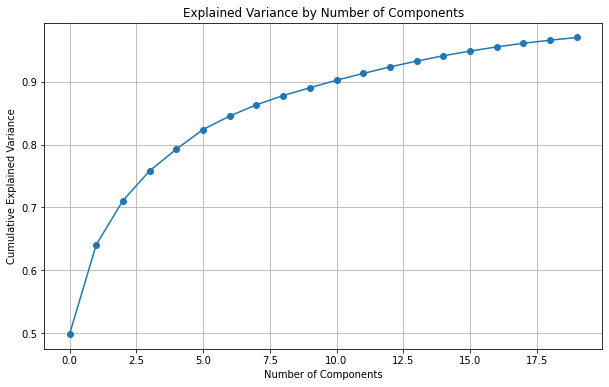

In [21]:
## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)

# Determine the number of components needed to reach 80% variance
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print("Cumulative Explained Variance:", cumulative_explained_variance)
print("Number of components to reach 95% variance:", num_components)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [23]:
# Lasso coefficients for principal components
lasso_coefs_pcs = grid_search.best_estimator_.named_steps['model_s'].coef_
components_sim = grid_search.best_estimator_.named_steps['pca_s'].components_

lasso_coefs_pcs_df = pd.DataFrame({'lasso_coef_PC':lasso_coefs_pcs})
#print lasso_coefs_pcs_df.head())

# Transform back to original feature space
original_feature_coefs = np.dot(components_sim.T, lasso_coefs_pcs)
# Create a DataFrame for easier interpretation
feature_names=X_train.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': original_feature_coefs})
print("Original Coefficient dataframe:\n")
print(coef_df)


# Sort the DataFrame by the absolute value of the coefficients for top 10 most inflential factors
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
df_top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(10)
print(" \n Top 10 features which impact BIN11 failures:\n",df_top_features[['Feature', 'Coefficient']])

Original Coefficient dataframe:

     Feature   Coefficient
0        Fab  5.433810e-19
1    Site ID  6.334109e-03
2      BV_N4  1.105952e-03
3     BV_N44  3.070227e-04
4     BV_N45  1.818315e-03
..       ...           ...
85  Vtl_NNGD -5.924119e-03
86    Vtl_P4 -3.992515e-04
87   Vtl_P45 -1.245098e-03
88  Vtl_P45L -1.067226e-03
89  Vtl_P4OD -5.868073e-04

[90 rows x 2 columns]
 
 Top 10 features which impact BIN11 failures:
        Feature  Coefficient
61      Rs_HRI     0.022375
71  Rs_PODRPO2     0.020197
16   Cmim40X50     0.019557
53   Iof_PTM9A    -0.019451
72  Rs_PPORPO2     0.018970
50    Iof_P45L    -0.017601
65  Rs_NODRPO2     0.016797
66  Rs_NPORPO2     0.016650
62  Rs_HRIserp     0.013830
67   Rs_NW_STI     0.013069


### Top 10 WAT impacting BIN11 from Ridge and Lasso

With >95% explained variance simulation, the top 10 features which impact the FT Bin11 are as followings.  First table is Lasso and the second table is Ridge

| Feature | Coefficient |
|----------|----------|
|  Rs_HRI   |  0.022375|
|Rs_PODRPO2  |   0.020197 |
|Cmim40X50  |   0.019557 |
|Iof_PTM9A |   -0.019451|
|Rs_PPORPO2  |   0.018970|
| Iof_P45L |   -0.017601 |
|Rs_NODRPO2  |   0.016797 |
| Rs_NPORPO2   |  0.016650 |
| Rs_HRIserp |    0.013830 |
| Rs_NW_STI  |   0.013069 |

| Feature | Coefficient|
|----------|----------|
| Rs_PODRPO2  |   0.012936|
| Iof_PTM9A |   -0.010889 |
| Cmim40X50 |    0.010483 |
|  Rc_TV1   |  -0.010032  |
| Rs_NODRPO2 |    0.009208 |
| Rs_HRI   |  0.008754   |
| Iof_P45  |  -0.008469|
| Rs_NW_STI |    0.008355 |
| Rs_NPORPO2 |    0.008239 |
| Rs_PPORPO2 |    0.007339|


In this analysis, I used PCA to reduce the component for easy analysis.  The PCA analysis ensures the components can represent 95% of the original data information.  Pipeline, lasso and ridge model with GridSearchCV are used for regression and optimized for hyperparameters for Ridge and Lasso model.  Compared the MSE to identify Ridge model is better than Lasso model.  Identified the top 10 features which influence the Bin11 failure the most. Lasso model top 10 features match with Ridge Model top 10 well (the sequences are different and only 2 parameters are different).  I think the WAT parameters are highly correlated with each others.  So it is better to use Ridge model.

Hold out validation of the test MSE shows Lasso = 0.043 and Ridge = 0.027

Futher debug reveals that FT pass / fail yield and bin failure rate might not be the best way to debug this issue, because the FT test instability was found due to ringing issues.
Final test (FT) was changed from pass / fail to POR circuit trip point parametric data collection.
Based on the new trip point data, redo the analysis using random forest regression, XGboost and Ridge model with GridSearchCV + feature permutation to find the most relevant WAT parameters.

In [1]:
# Redo the analysis with the new BIN11 parameteric data with Random Forest, XGboost and Ridge Models

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split,GridSearchCV

In [81]:
from sklearn.metrics import mean_squared_error 
from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above
import pydotplus
from sklearn.tree import export_graphviz

In [34]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pydotplus
from sklearn.tree import export_graphviz

## Data Analysis
Load FB FEM data separately and drop all non-WAT columns. All non-numerical columns can be dropped
Check if any Null and drop Null.

In [35]:
pcm_trippoint=pd.read_csv('data/new/Austin F14 VPOR-trans PCM new-20241025a.csv')
print(pcm_trippoint.isnull().sum()) ## Check Null values
## Check data types by info.
print(" Data Type Summary")
print (pcm_trippoint.info())

Source Lot         0
Lot                0
Wafer Number       0
PCMx               0
PCMy               0
                ... 
Vtl_P45         1542
Vtl_P45L        1542
Vtl_P46         1541
Vtl_P4L         1541
Vtl_P4OD        1542
Length: 164, dtype: int64
 Data Type Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135 entries, 0 to 2134
Columns: 164 entries, Source Lot to Vtl_P4OD
dtypes: float64(156), int64(4), object(4)
memory usage: 2.7+ MB
None


In [36]:
## Data is a combination of objects with 4 objects.
## Data contain NaN

### Data Preparation

After our initial exploration and fine tuning of the business understanding, 
it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), 
and general preparation for modeling with `sklearn`. 

In [37]:
# Drop NAN
pcm_trippoint=pcm_trippoint.dropna()

In [38]:
# Drop all object columns
object_cols=pcm_trippoint.select_dtypes('object').columns.tolist()
pcm_trippoint = pcm_trippoint.drop(object_cols,axis =1)
##Drop other non-WAT numerical columns
columns_to_drop = ['PCMx','PCMy','site','Wafer Number','Count()','1','10','14','11','12','16','18','19','22','23','26','27','28','29','30','42','43','44','8','9','99','13']
pcm_trippoint = pcm_trippoint.drop(columns=[col for col in columns_to_drop if col in pcm_trippoint.columns])
pcm_trippoint.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 0 to 593
Columns: 156 entries, VPOR_FirstTripPoint to Vtl_P4OD
dtypes: float64(156)
memory usage: 713.9 KB


In [39]:
## Check data again with head()
pcm_trippoint.head()

,VPOR_FirstTripPoint,Site ID,BV_N+PW,BV_N4,BV_N44,BV_N45,BV_N45N,BV_N45SA,BV_N46,BV_N46SA,...,Vtl_N4SA,Vtl_N5A6SB,Vtl_NFGD,Vtl_NNGD,Vtl_P4,Vtl_P45,Vtl_P45L,Vtl_P46,Vtl_P4L,Vtl_P4OD
0,2.339333,1.0,8.2544,4.0,9.9,9.9,0.1,9.7,9.9,9.7,...,0.656,0.738,1.823,0.809,-0.638,-0.893,-0.796,-0.915,-0.204,-0.607
1,2.330781,2.0,8.2580,4.0,9.9,10.0,0.1,9.7,9.9,9.7,...,0.645,0.746,1.822,0.807,-0.622,-0.889,-0.793,-0.907,-0.203,-0.597
2,2.334305,3.0,8.2892,4.0,9.9,10.0,0.1,9.7,10.0,9.7,...,0.634,0.761,1.825,0.807,-0.626,-0.900,-0.792,-0.913,-0.201,-0.598
3,2.343267,4.0,8.2808,3.9,10.0,10.0,0.1,9.7,10.0,9.7,...,0.643,0.759,1.824,0.807,-0.623,-0.891,-0.795,-0.914,-0.201,-0.603
4,2.348924,5.0,8.2732,3.9,10.0,10.0,0.1,9.7,10.0,9.7,...,0.649,0.740,1.819,0.803,-0.635,-0.891,-0.792,-0.909,-0.203,-0.600


## Modeling
To determine which WAT (Wafer Acceptance Test) parameters contribute to the differences in VPOR_UPPER_ trip point.
Feature Importance Analysis Use a machine learning model to identify the most important features (WAT parameters) that influence VPOR_UPPER_trip point. Models like Random Forest or Gradient Boosting can provide feature importance scores.

1.  The first model I plan to use RandomForestRegressor with permutation to find the best n_estimator.  Plot residue plot of actual and prediction delta.  Check test dataset MSE.  Check the top 5 WAT which affects the POR trip point values from both positive and negative side.  Visualize the tree model.

2. Redo analysis with Ridge Model, because from the yield data analysis on 11/17, looks like Ridge model is better than Lasso model.  So will use Ridge for this new data analysis.



In [96]:
# Define the features (WAT parameters) and target variable
features = pcm_trippoint.drop(columns=['VPOR_FirstTripPoint'])
target = pcm_trippoint['VPOR_FirstTripPoint']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [41]:
#Define the Parameter Grid: Create a range of values for n_estimators to find the best hyperparameter
param_grid = {'n_estimators': [50, 100, 150]}

#Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

#Set Up GridSearchCV: Use GridSearchCV to perform cross-validation and find the best n_estimators
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

#Get the Best Parameters
best_params = grid_search.best_params_
print(f"Best n_estimators: {best_params['n_estimators']}")

Best n_estimators: 150


In [72]:
# Use the best model from the GridSearch to check the predicted values on test data and MSE
best_model = grid_search.best_estimator_

# Make preidction using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
# Calculate and print the Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train,y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f' Train Mean Squared Error: {mse_train}')
print(f' Test Mean Squared Error: {mse_test}')

 Train Mean Squared Error: 2.7402834867335024e-05
 Test Mean Squared Error: 0.00020651086359358185


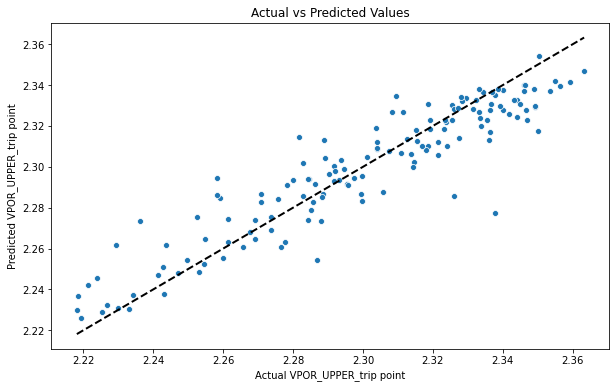

In [73]:
# Plot the actual vs predicted values

# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
# Visualize the actual vs predict POR trip point value                             
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual VPOR_UPPER_trip point')
plt.ylabel('Predicted VPOR_UPPER_trip point')
plt.show()

In [82]:
# Tree Visualization

#Extract feature names from the DataFrame
feature_names = features.columns
# Export a single tree from the forest
estimator = best_model.estimators_[0]
# Export the decision tree to DOT format
dot_data = export_graphviz(estimator, out_file=None, 
                           feature_names=feature_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  
# Generate the graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Save the graph as a PNG file
graph.write_png("data/new/tree-rf-12-14.png")

True

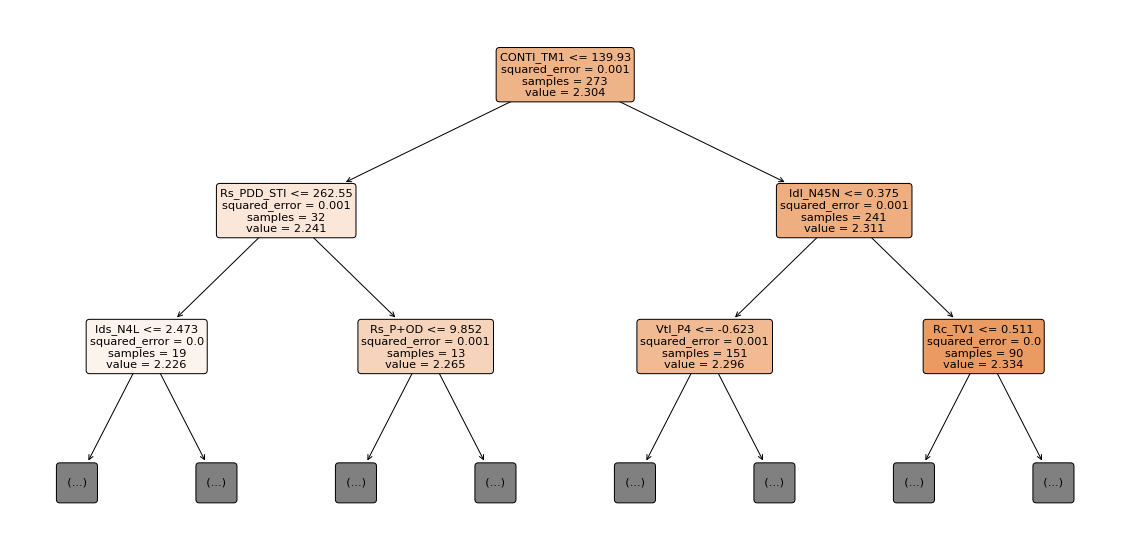

In [103]:
# Visualize one of the trees\
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(best_model.estimators_[1], feature_names=feature_names, filled=True, rounded=True, max_depth = 2)
plt.show()

In [50]:
## Permutation to check the importance of the features

from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for better visualization
perm_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 5 most important features
print("Top 5 most important features:\n", perm_importance_df.head())
print("Top 5 most important negative features:\n", perm_importance_df.tail())
# Ensure the data is in the correct format
perm_importance_df['Importance'] = perm_importance_df['Importance'].astype(float)
print(type(perm_importance))
perm_importance_df.head()

Top 5 most important features:
         Feature  Importance
119  Rs_PDD_STI    0.137198
30    CONTI_TM1    0.136404
39     Idl_N45N    0.064990
28     CONTI_M3    0.042584
105      Rc_TV1    0.026548
Top 5 most important negative features:
         Feature  Importance
50     Idl_P45L   -0.000223
110  Rs_HRIserp   -0.000301
116  Rs_NWODRPO   -0.000348
131    Vtg_NNGD   -0.000362
108  Rs_DPW_STI   -0.000636
<class 'sklearn.utils._bunch.Bunch'>


,Feature,Importance
119,Rs_PDD_STI,0.137198
30,CONTI_TM1,0.136404
39,Idl_N45N,0.064990
28,CONTI_M3,0.042584
105,Rc_TV1,0.026548


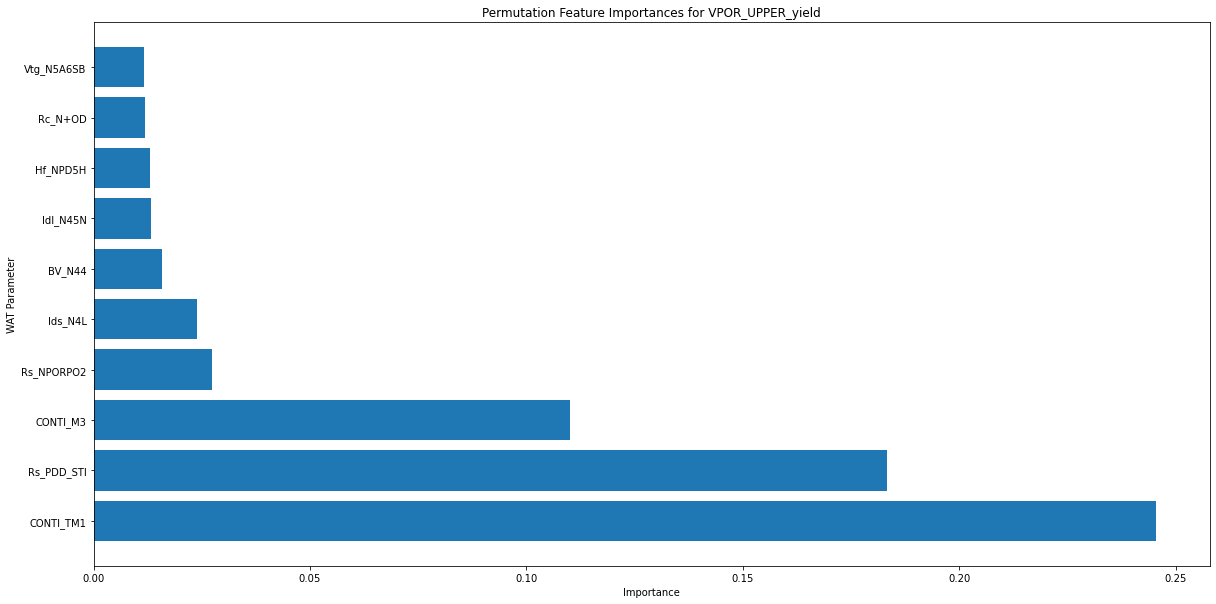

In [94]:
# Plot the permutation feature importances of top 10 features
top_10=perm_importance_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(20, 10))
plt.barh(top_10['Feature'], top_10['Importance'])
plt.title('Permutation Feature Importances for VPOR_UPPER_yield')
plt.xlabel('Importance')
plt.ylabel('WAT Parameter')
plt.show()

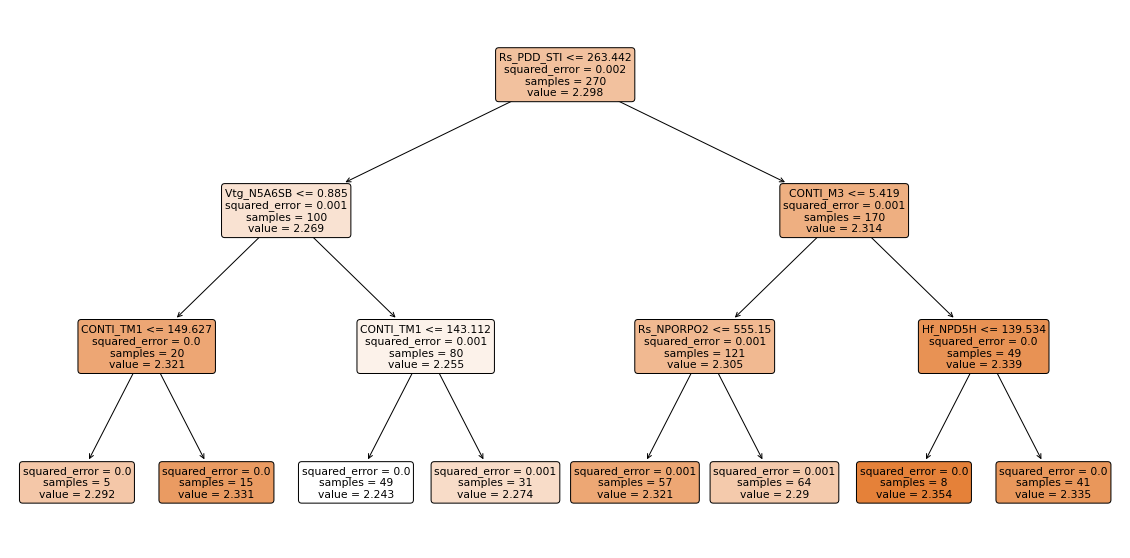

In [102]:
# Select top 10 features
top_features = perm_importance_df.head(10)['Feature'].tolist()

# Create a new dataset with only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
# Train a new Random Forest model with the top features
top_model = RandomForestRegressor(n_estimators=10, max_depth=3)
top_model.fit(X_train_top, y_train)

# Visualize one of the trees
plt.figure(figsize=(20,10))
plot_tree(top_model.estimators_[1], feature_names=top_features, filled=True, rounded=True)
plt.show()

In [60]:
## Use Ridge model and new  BIN 11 parameteric data to check the importance of the parameters

## Build a Pipeline to optimize Ridge model hyperparameters and PCA components in the ridge_param_dict to optimize alpha, Solver
## fit intercept and pca components

ridge_para_dict=''
ridge_pipe=''
ridge_train_mse=''
ridge_test_mse=''

# Define the parameter grid
ridge_param_dict = {
    'model_s__alpha': np.linspace(0, 2000, 10),
    'model_s__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'model_s__fit_intercept': [True, False],
    'pca_s__n_components': [12, 20, 25, 60, 70, 80, 88]
}
ridge_pipe = Pipeline([('pca_s',PCA()),('model_s', Ridge())])

# Initialize GridSearchCV
ridge_grid = GridSearchCV(ridge_pipe,param_grid = ridge_param_dict,cv=5)
ridge_grid.fit(X_train,y_train)

# Retrieve the best model
best_model = ridge_grid.best_estimator_

# Predictions and MSE
ridge_train_preds=best_model.predict(X_train)
ridge_test_preds =best_model.predict(X_test)
ridge_train_mse = mean_squared_error(ridge_train_preds,y_train)
ridge_test_mse = mean_squared_error(ridge_test_preds,y_test)
print(f'Train MSE with Gridsearch: {ridge_train_mse}')
print(f'Test MSE with Gridsearch: {ridge_test_mse}')


Train MSE with Gridsearch: 0.00017942668525017176
Test MSE with Gridsearch: 0.0002614496578446856


best alpha value 0.0
Number of components to reach 95% variance: 1
Number of PCA components selected: 70


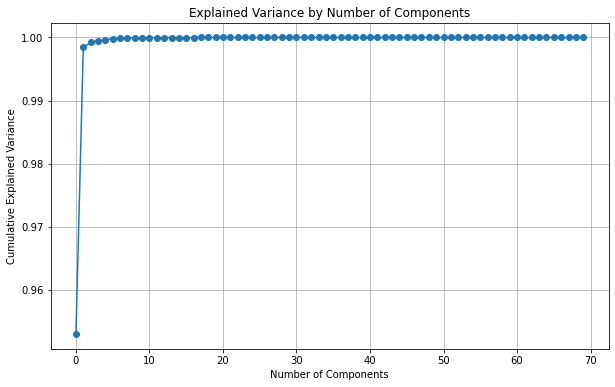

 
 Top 10 features which impact BIN11 failures:
        Feature  Coefficient
1      BV_N+PW    -0.247753
29    CONTI_PO    -0.157667
25   Cmim40X50     0.146876
107      Rc_V2     0.107226
79   Ids_PTM9A    -0.103904
40   Idl_N45SA     0.093680
18     BV_P45L     0.081867
106      Rc_V1    -0.071344
8     BV_N46SA    -0.068436
73     Ids_P45     0.066941


In [64]:
## To see the explained variance ratio of each principal component
explained_variance = ridge_grid.best_estimator_.named_steps['pca_s'].explained_variance_ratio_
#print(f"explained variance ratio of the PCA components:{explained_variance}")

## Find the best alpha
best_alpha=ridge_grid.best_params_['model_s__alpha']
print("best alpha value",best_alpha)

## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)

# Determine the number of components needed to reach 95% variance
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
#print("Cumulative Explained Variance:", cumulative_explained_variance)
print("Number of components to reach 95% variance:", num_components)

# Extract the number of PCA components
n_components =ridge_grid.best_params_['pca_s__n_components']
print(f"Number of PCA components selected: {n_components}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

# Ridge coefficients for principal components
ridge_coefs_pcs = ridge_grid.best_estimator_.named_steps['model_s'].coef_
components_sim = ridge_grid.best_estimator_.named_steps['pca_s'].components_

#print("ridge coef:",ridge_coefs_pcs)
ridge_coefs_pcs_df = pd.DataFrame({'ridge_coef_PC':ridge_coefs_pcs})
#print (ridge_coefs_pcs_df.head())

# Transform back to original feature space
original_feature_coefs = np.dot(components_sim.T, ridge_coefs_pcs)
# Create a DataFrame for easier interpretation
feature_names=X_train.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': original_feature_coefs})

# Sort the DataFrame by the absolute value of the coefficients for top 10 most inflential factors
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
df_top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(10)
print(" \n Top 10 features which impact BIN11 failures:\n",df_top_features[['Feature', 'Coefficient']])


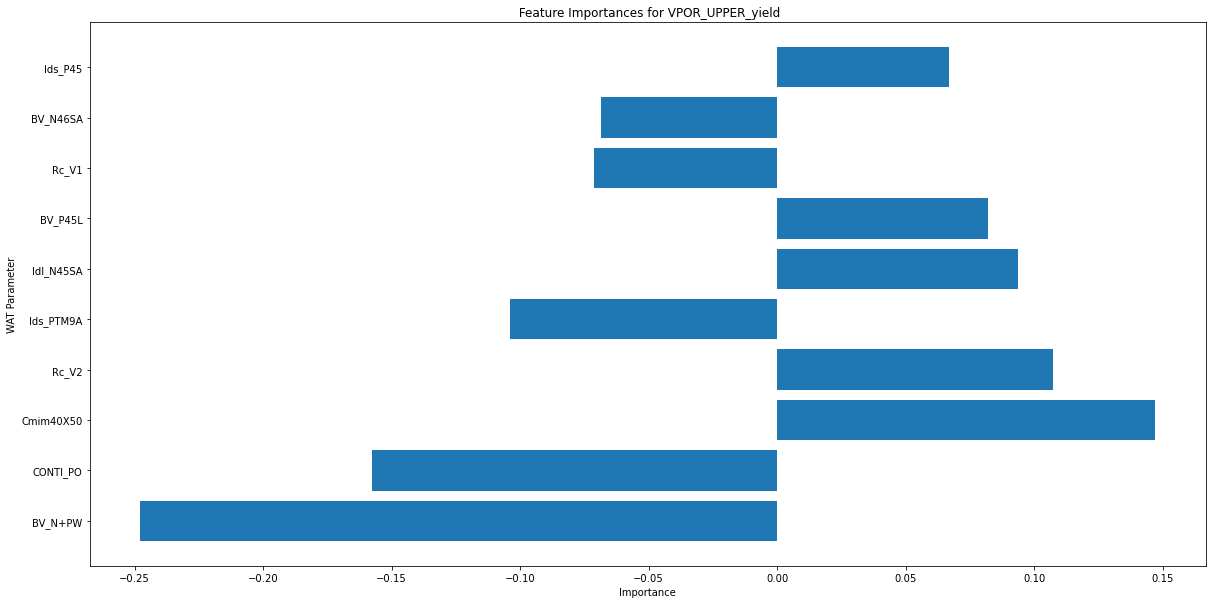

In [67]:
df_top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(10)
plt.figure(figsize=(20, 10))
plt.barh(df_top_features['Feature'],df_top_features['Coefficient'])
plt.title(' Feature Importances for VPOR_UPPER_yield')
plt.xlabel('Importance')
plt.ylabel('WAT Parameter')
plt.show()

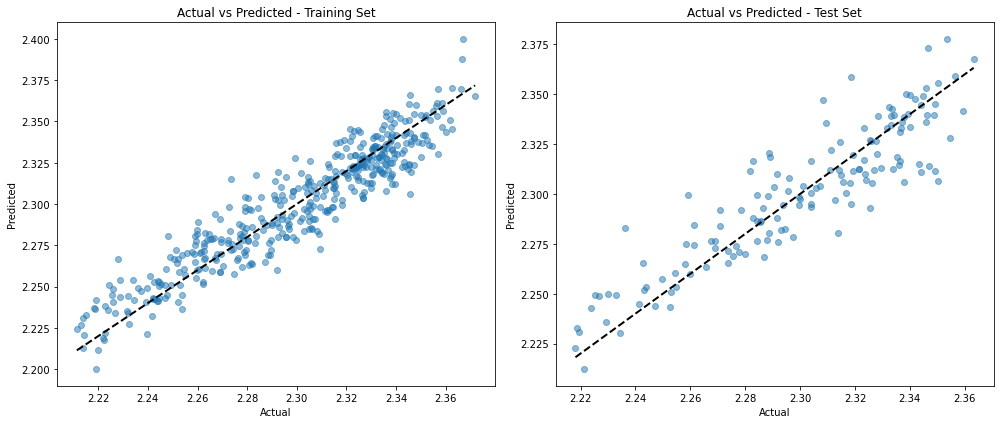

In [65]:
# Plotting Actual vs Predicted for Training set
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, ridge_train_preds, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Training Set')

# Plotting Actual vs Predicted for Test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Test Set')

plt.tight_layout()
plt.show()

In [69]:
## use XGBoost to find the MeanSquare error and top 10 important feature
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd

In [71]:
#Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# Train the model
xgb_regressor.fit(X_train, y_train)
# Predict on training and testing sets
train_preds = xgb_regressor.predict(X_train)
test_preds = xgb_regressor.predict(X_test)
# Calculate Mean Squared Error (MSE) for training and testing sets
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE with XGBoost: {train_mse}')
print(f'Test MSE with XGBoost: {test_mse}')

Train MSE with XGBoost: 2.0023503796164772e-07
Test MSE with XGBoost: 0.00024875414952773043


In [74]:
# Get feature importances
feature_importances = xgb_regressor.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and get the top 10 features
top_10_features = feature_importances_df.sort_values(by='Importance', ascending=False).head(10)

print("Top 10 Important Features:")
print(top_10_features)

Top 10 Important Features:
        Feature  Importance
119  Rs_PDD_STI    0.173565
30    CONTI_TM1    0.116487
149      Vtl_P4    0.089847
129  Vtg_N5A6SB    0.057017
114  Rs_NPORPO2    0.046682
28     CONTI_M3    0.043036
63      Ids_N4L    0.033923
125   Vt_FNGD27    0.025594
39     Idl_N45N    0.023196
140   Vtl_N46SA    0.022558


In [75]:
## Permutation to check the importance of the features

from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
perm_importance = permutation_importance(xgb_regressor, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for better visualization
perm_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 5 most important features
print("Top 5 most important features:\n", perm_importance_df.head())
print("Top 5 most important negative features:\n", perm_importance_df.tail())
# Ensure the data is in the correct format
perm_importance_df['Importance'] = perm_importance_df['Importance'].astype(float)
print(type(perm_importance))
perm_importance_df.head()

Top 5 most important features:
         Feature  Importance
30    CONTI_TM1    0.245546
119  Rs_PDD_STI    0.183315
28     CONTI_M3    0.109992
114  Rs_NPORPO2    0.027318
63      Ids_N4L    0.023898
Top 5 most important negative features:
         Feature  Importance
36       Idl_N4   -0.001558
145    Vtl_N4SA   -0.001565
110  Rs_HRIserp   -0.001805
106       Rc_V1   -0.001836
26     CONTI_M1   -0.003171
<class 'sklearn.utils._bunch.Bunch'>


,Feature,Importance
30,CONTI_TM1,0.245546
119,Rs_PDD_STI,0.183315
28,CONTI_M3,0.109992
114,Rs_NPORPO2,0.027318
63,Ids_N4L,0.023898


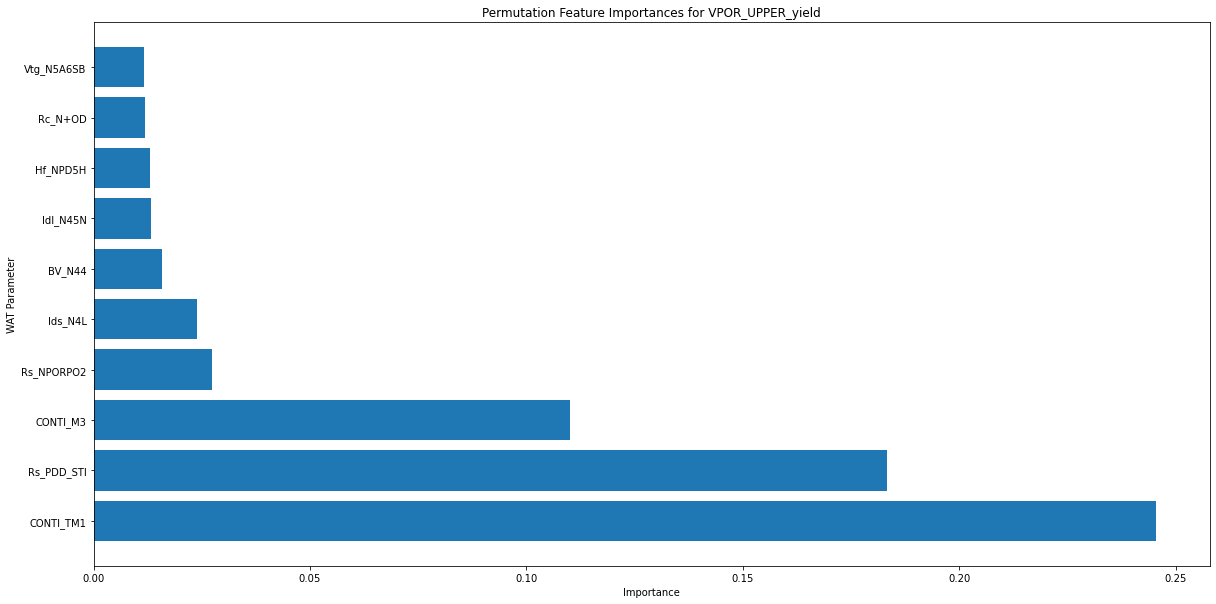

In [76]:
# Plot the permutation feature importances of top 10 features
top_10_xg = perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(20, 10))
plt.barh(top_10_xg['Feature'], top_10_xg['Importance'])
plt.title('Permutation Feature Importances for VPOR_UPPER_yield')
plt.xlabel('Importance')
plt.ylabel('WAT Parameter')
plt.show()

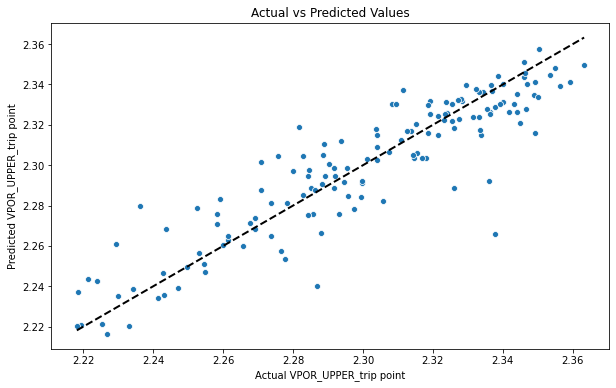

In [78]:
# Plot the actual vs predicted values

# Create a DataFrame to compare actual vs predicted values
comparison_df_xg = pd.DataFrame({'Actual': y_test, 'Predicted': test_preds})
# Visualize the actual vs predict POR trip point value                             
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df_xg)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual VPOR_UPPER_trip point')
plt.ylabel('Predicted VPOR_UPPER_trip point')
plt.show()

## Summary

With the new dataset, compared three models

1. Random Forest Model with GridSearchCV to optimize the n_estimator, then use permutation to find the most relevant features (WAT parameters) which contributed to the POR trip point values.  Visualize the predicted values vs actual values and MSE.  Very good testing MSE  Train Mean Squared Error: 2.7402834867335024e-05
 Test Mean Squared Error: 0.00020651086359358185.  Then Visualize the random forest trees.  
 
 2. Ridge model with GridSearchCV to optimize    'model_s__alpha': np.linspace(0, 2000, 10),
    'model_s__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'model_s__fit_intercept': [True, False],
    'pca_s__n_components': [12, 20, 25, 60, 70, 80, 88].  Visualize the actual vs prediction.  Very good MSE for test and train. Train MSE with Gridsearch: 0.00017942668525017176
Test MSE with Gridsearch: 0.0002614496578446856
Extracted top 5 features (PCM parameters)
  3. Use XGD model and permutation.  Extracted the top 5 features.  Very good test MSE
Train MSE with XGBoost: 2.0023503796164772e-07
Test MSE with XGBoost: 0.00024875414952773043

From the top 5 feature comparisons among the 3 models, the two ensemble models show 3/5 features are the same.  The top 2 features are the same Rs_PDD_STI and CONT1_TM1.  The Ridge model shows very different features.  Since the PCM parameter and POR trip point measurement are non-linear, I think we will use Ensemble model as reference for the problem debug

# Top 5 feature comparison between 3 models

|Random Forest|	XGD|Ridge|Importance|
|----------|----------|----------|----------|
|Rs_PDD_STI|CONTI_TM1|BV_N+PW	|Top-1 |
|CONTI_TM1	|Rs_PDD_STI|CONTI_PO |Top-2 |
|Idl_N45N	|CONTI_M3 |Cmim40X50|Top-3|
|CONTI_M3	|Rs_NPORPO2|Rc_V2|Top-4|
|Rc_TV1	  |Ids_N4L|Ids_PTM9A |Top=5|
